# Neural Network Convolutional Decoder

Julien Doe

## Background

In the effort to develop a neural network turbo decoder, we will start by looking at a neural network convolutional decoder. The goal is to develop a decoder implementation which rivals the BER performance of a maximum a posteriori (MAP) decoder.

## Imports

In [184]:
# Common
import os
import numpy as np
import scipy as sp
import pandas as pd

# DSP
from math import log10

# Neural Network
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import Model
from keras.layers import Input, Dense, LSTM, Add
from keras.models import clone_model
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt

## Helper Functions

In [110]:
def rms(x):
    return np.sqrt(np.mean(np.array(x)**2))

## Encoders

We will utilize the encoders listed in the convolutional encoder Wikipedia page: https://en.wikipedia.org/wiki/Convolutional_code



### Two State

From Wikipedia page, Figure 3:

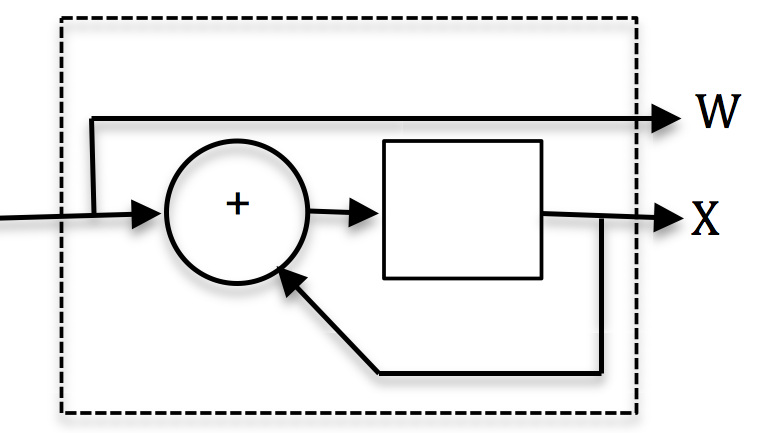


In [111]:
def encode2(data):
    # Cast input to Boolean
    data = np.array(data).astype(bool)

    # Initialize
    state = np.zeros(1, dtype=bool)
    code = np.zeros((2*len(data)), dtype=bool)

    # Iterate
    for i in range(0, len(code), 2):
        # Set systematic output
        systematic = data[np.floor(i/2).astype(int)]
        code[i] = systematic

        # Set parity output
        code[i+1] = state

        # Update state
        state = np.logical_xor(code[i], state)

    # Return
    return code.astype(int)

### Four State

From Wikipedia page, Figure 4:

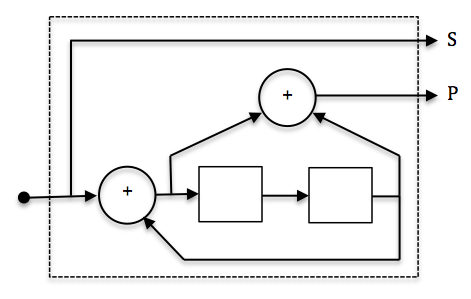



In [112]:
def encode4(data):
    # Cast input to Boolean
    data = np.array(data).astype(bool)

    # Initialize
    state = np.zeros(2, dtype=bool)
    code = np.zeros(2*len(data), dtype=bool)

    # Iterate
    for i in range(0, len(code), 2):
        # Set systematic output
        systematic = data[np.floor(i/2).astype(int)]
        code[i] = systematic

        # Set parity output
        temp = np.logical_xor(state[1], systematic)
        code[i+1] = np.logical_xor(state[1], temp)

        # Update state
        state[1:-1] = state[0:-2]
        state[0] = temp

    # Return
    return code.astype(int)

### Sixteen State

From Wikipedia page, Figure 5:

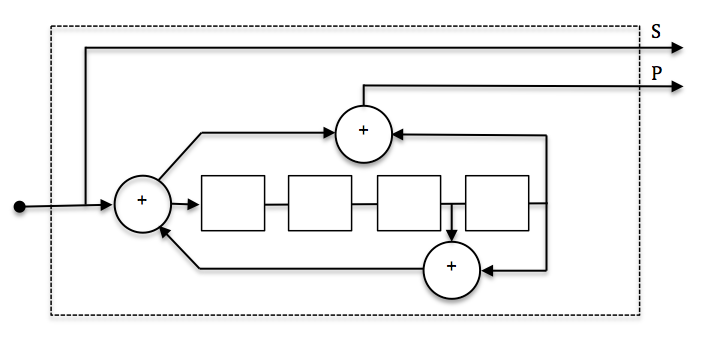

In [113]:
def encode16(data):
    # Cast input to Boolean
    data = np.array(data).astype(bool)

    # Initialize
    state = np.zeros(4, dtype=bool)
    code = np.zeros(2*len(data), dtype=bool)

    # Iterate
    for i in range(0, len(code), 2):
        # Set systematic output
        systematic = data[np.floor(i/2).astype(int)]
        code[i] = systematic

        # Set parity output
        temp1 = np.logical_xor(state[2], state[3])
        temp2 = np.logical_xor(temp1, systematic)
        code[i+1] = np.logical_xor(state[3], temp2)

        # Update state
        state[1:-1] = state[0:-2]
        state[0] = temp2

    # Return
    return code.astype(int)

## Link

Next we will develop our model for the modulator, channel and demodulator.

For now we want to work with the simplest model. We will use the following setup:
- BPSK
- No pulse shaping or matched filtering
- Baseband (no upconversion)
- Additive white Gaussian noise channel

We can work with higher order modulations and more distortions later, but for now we will get a simple model working


In [121]:
def modulate(bits):
    # Convert to BPSK symbols
    symbols = 2 * np.array(bits) - 1

    # Return
    return symbols

In [122]:
def channel(tx, snrDB):
    # Cast input to numpy array
    tx = np.array(tx)

    # Determine added noise power
    PsignalDB = 10*log10(rms(tx)**2)
    PnoiseDB = PsignalDB - snrDB
    
    # Generate noise
    nsamples = len(tx)
    sd = 10**(PnoiseDB / 20)
    if np.any(np.iscomplex(tx)):
        awgn = np.random.normal(0, sd, nsamples) + 1j*np.random.normal(0, sd, nsamples)
    else:
        awgn = np.random.normal(0, sd, nsamples)

    # Add to signal
    rx = tx + awgn

    # Return
    return rx

In [123]:
def demodulate(rx):
    # Just a passthrough for now
    return rx

In [124]:
def link(bits, snrDB):
    return demodulate(channel(modulate(bits), snrDB))

## Data

With our encoder and link defined, we can generate our data set.

One important note is that our model isn't going to output the recovered data (pre encoder), it is going to output the corrected codeword (post encoder). Specifically, it is going to output the corrected LLRs. This is done for two reasons:

1. It is possible to do multiiple iterations of decoding, as is done in Turbo decoding. Thus we want the output to be effectively the same type of data as the input (albiet corrected) so that it can be plugged back in. Outputting the original data limits it to one iteration
2. It is a trivial operation to make a decision on the bits at any point and recover the original data.

Some other notes:
1. We will generate random sets of input bits
2. We want the model to be agnostic to message length, so we will also randomize the message lengths (within reasonable bounds)
3. Instead of generating LLRs the typical way, we will later give the model an extra Dense layer after the input and let it form it's own LLRs



In [137]:
# Data Parameters
MIN_LENGTH = 10
MAX_LENGTH = 100
NUM_EXAMPLES = 1

# DSP Parameters
BITS_PER_SYMBOL = 1
SNR = 30

# Data
inputs = []
outputs = []

for i in range(NUM_EXAMPLES):
    # Generate bits
    nbits = np.random.randint(low=MIN_LENGTH, high=MAX_LENGTH, size=1)
    bits = np.random.randint(low=0, high=2, size=nbits)

    # Input
    inputs.append(link(bits, SNR))
    
    # Target
    outputs.append(2 * bits - 1)

## Model

This model will be set up as a sequence-to-sequence (seq2seq) LSTM model

### LLR Generator

We will use a single dense layer to generate LLRs. While this is a trivial task for BPSK and could be done with a convential approach, we want to try and generate a model which can be generalized to higher order modulations

In [158]:
# Model Parameters
NUM_LLR_HIDDEN = 4

# Build Model
input = Input(shape = (None, 2), name = 'input') # First dimension is none for time series data, second is 2 for I and Q
hidden = Dense(NUM_LLR_HIDDEN,
    name = 'hidden',
    activation = 'relu',
    use_bias = True, # Allow bias
    kernel_initializer = 'glorot_uniform', # Standard initializer
    kernel_regularizer = None, # Small dropout
    dtype = 'float32')(input)
output = Dense(BITS_PER_SYMBOL, # Want one output per symbol bit
    name = 'output',
    activation = 'tanh', # Maps to -1 < x < 1
    use_bias = True, # Allow bias
    kernel_initializer = 'glorot_uniform', # Standard initializer
    kernel_regularizer = None, # No regularizer
    dtype = 'float32')(hidden)
llr = Model(inputs = input, outputs = output, name='llr_calculator')

# Compile
llr.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
llr.summary()

Model: "llr_calculator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, None, 4)        │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 1)        │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

### Common Layer Setup

In [178]:
# Model Parameters
NUM_DENSE_HIDDEN = 16
NUM_LSTM = 8

# Input
common_input = Input(shape = (None, BITS_PER_SYMBOL), name = 'input')
common_input_shape = (None, BITS_PER_SYMBOL)

# Dense Hidden Layer
common_dense = Dense(NUM_DENSE_HIDDEN,
    name = 'hidden',
    activation = 'relu',
    use_bias = True, # Allow bias
    kernel_initializer = 'glorot_uniform', # Standard initializer
    kernel_regularizer = None, # Small dropout
    dtype = 'float32')

# LSTM Layer
common_lstm = LSTM(NUM_LSTM,
    name = 'lstm', 
    activation = 'tanh',
    recurrent_activation = 'sigmoid',
    use_bias = True,
    kernel_initializer = 'glorot_uniform', 
    recurrent_initializer = 'orthogonal',
    kernel_regularizer = None,
    recurrent_regularizer = None, 
    return_sequences=True,
    return_state=False,
    use_cudnn=False)

# Output Layer
common_output = Dense(BITS_PER_SYMBOL, # Want one output per symbol bit
    name = 'output',
    activation = 'tanh', # Maps to -1 < x < 1
    use_bias = True, # Allow bias
    kernel_initializer = 'glorot_uniform', # Standard initializer
    kernel_regularizer = None, # No regularizer
    dtype = 'float32')


### Simple Dense

In [181]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')
hidden = clone_model(common_dense)(input)
output = clone_model(common_output)(hidden)
simple = Model(inputs = input, outputs = output, name='simple_dense')

# Compile
simple.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
simple.summary()

Model: "simple_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, None, 16)       │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49 (196.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

### Single LSTM

In [ ]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')
lstm = clone_model(common_lstm)(input)
output = clone_model(common_output)(lstm)
single = Model(inputs = input, outputs = output, name='single_lstm')

# Compile
single.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
single.summary()

Model: "single_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 8)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

### Single LSTM with Residual Connection

In [190]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')
lstm = clone_model(common_lstm)(input)
dense = clone_model(common_output)(lstm)
output = Add()([dense, input])
single_res = Model(inputs = input, outputs = output, name='single_lstm_residual')

# Compile
single_res.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
single_res.summary()

Model: "single_lstm_residual"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, None, 8)   │        320 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, None, 1)   │          9 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 1)   │          0 │ output[0][0],     │
│                     │                   │            │ input[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

### Multilayer LSTM

In [192]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')

temp = clone_model(common_lstm)
temp._name = 'lstm1'
lstm1 = temp(input)

temp = clone_model(common_lstm)
temp.name = 'lstm2'
lstm2 = temp(lstm1)

output = clone_model(common_output)(lstm2)
multi = Model(inputs = input, outputs = output, name='multi_lstm')

# Compile
multi.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
multi.summary()

Model: "multi_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 8)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, None, 8)        │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

### Multilayer LSTM with Residual Connection

Residual connection to the end

In [193]:
# Build Model
input = Input(shape = common_input_shape, name = 'input')

temp = clone_model(common_lstm)
temp._name = 'lstm1'
lstm1 = temp(input)

temp = clone_model(common_lstm)
temp.name = 'lstm2'
lstm2 = temp(lstm1)

dense = clone_model(common_output)(lstm2)
output = Add()([dense, input])

multi_res = Model(inputs = input, outputs = output, name='multi_lstm')

# Compile
multi_res.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

# Summarize
multi_res.summary()

Model: "multi_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, None, 8)   │        320 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm2 (LSTM)        │ (None, None, 8)   │        544 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, None, 1)   │          9 │ lstm2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 1)   │          0 │ output[0][0],     │
│                     │                   │            │ input[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

### Transformer

Encoder/Decoder structure